In [20]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 75499, done.
remote: Counting objects: 100% (301/301), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 75499 (delta 161), reused 272 (delta 149), pack-reused 75198
Receiving objects: 100% (75499/75499), 580.73 MiB | 713.00 KiB/s, done.
Resolving deltas: 100% (53552/53552), done.
cp: cannot create regular file '/usr/share/fonts/truetype/dejavu/arial.ttf': Permission denied


##### Use absolute paths EVERYWHERE

In [46]:
# install object_detection library
! cd /home/sr42/catkin_ws/src/vayubhoomi-uav-ugv/src/vision/src/wasteTensorflow/models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver . 

# fix for 'ImportError: cannot import name 'string_int_label_map_pb2' from 'object_detection.protos' (/home/sr42/.local/lib/python3.8/site-packages/object_detection/protos/__init__.py)' 
import sys
sys.path.append("..") 
from protos import string_int_label_map_pb2

# fix for failure to import datasset_util, label_map_util
! cd /home/sr42/catkin_ws/src/vayubhoomi-uav-ugv/src/vision/src/wasteTensorflow/models/research/object_detection
from utils import label_map_util, dataset_util


Usage:   
  /bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /bin/python3 -m pip install [options] [-e] <local project path> ...
  /bin/python3 -m pip install [options] <archive url/path> ...

no such option: --use-feature


In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import json
import os
import cv2
from object_detection.utils import visualization_utils as vis_util
from sklearn.cluster import KMeans

In [81]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [99]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)
            return int(num)

In [100]:
#DATA_DIR = './dataset/data'
#ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60

In [101]:
with open('/home/sr42/catkin_ws/src/vayubhoomi-uav-ugv/src/vision/src/wasteTensorflow/dataset/data/annotations.json') as json_file:
    data = json.load(json_file)
    
categories = data['categories']

In [102]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('./labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('./labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [103]:
label_map = label_map_util.load_labelmap('labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [104]:
detection_graph = reconstruct("/home/sr42/catkin_ws/src/vayubhoomi-uav-ugv/src/vision/src/wasteTensorflow/trained-models/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


2022-07-23 05:46:09.009777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 05:46:09.010143: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-23 05:46:12.672854: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 95883264 exceeds 10% of free system memory.


2


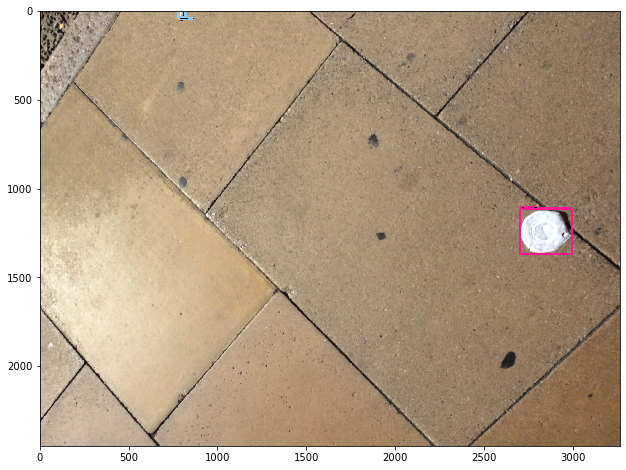

array([[[135, 133, 110],
        [132, 130, 109],
        [139, 136, 117],
        ...,
        [151, 121,  95],
        [144, 114,  88],
        [136, 106,  80]],

       [[137, 135, 112],
        [130, 128, 107],
        [132, 129, 110],
        ...,
        [151, 121,  95],
        [147, 117,  91],
        [144, 114,  88]],

       [[141, 139, 118],
        [134, 132, 111],
        [134, 131, 112],
        ...,
        [148, 118,  92],
        [149, 119,  93],
        [150, 120,  94]],

       ...,

       [[191, 172, 155],
        [190, 171, 154],
        [190, 171, 154],
        ...,
        [129,  96,  65],
        [117,  84,  53],
        [107,  74,  43]],

       [[189, 170, 153],
        [189, 170, 153],
        [189, 170, 153],
        ...,
        [131,  98,  67],
        [116,  83,  52],
        [104,  71,  40]],

       [[189, 170, 153],
        [189, 170, 153],
        [190, 171, 154],
        ...,
        [135, 102,  71],
        [125,  92,  61],
        [116,  83,  52]]

In [109]:
# example of detection
detect(detection_graph, '/home/sr42/catkin_ws/src/vayubhoomi-uav-ugv/src/vision/src/wasteTensorflow/dataset/data/batch_3/IMG_4852.JPG')

In [ ]:
# a function to record the positions of interest

def recordPoint(x, y):
     # currently focusing on appending to text file, although a pandas dataframe will be a more appropriate data structure for collecting recon data
    file = open('poi.csv', 'a')
    file.write(str(x) + ',' + str(y) + '\n')
    file.close()

In [ ]:
# running a video and collecting all the points of interest 
  
# This will return video from the first webcam on your computer.
cap = cv2.VideoCapture('video.mp4')  
frameNumber = 0

# point of interest file initialization
file = open('/home/sr42/catkin_ws/src/vayubhoomi-uav-ugv/src/vision/src/wasteTensorflow/poi.csv', 'a')
file.write('x,y\n')
file.close()

# initializing the positions dataframe
df = pd.read_csv('../positions.csv')

# loop runs if capturing has been initialized. 
while(True):

    # reads frames from a camera 
    # ret checks return at each frame
    ret, frame = cap.read() 
    cv2.imwrite('image.jpg', frame)
      
    frameNumber += 1
    index = frameNumber - 1

    # detecting the number of objects
    numObjs = detect(detection_graph, '/home/sr42/catkin_ws/src/vayubhoomi-uav-ugv/src/vision/src/wasteTensorflow/image.jpg')

    if numObjs > 0:
        recordPoint(df['x'][index], df['y'][index])
  
    cv2.waitKey(1) 
  
# Close the window / Release webcam
cap.release()
  
# De-allocate any associated memory usage 
cv2.destroyAllWindows()

In [ ]:
# importing poi.csv
dataset = pd.read_csv('poi.csv')
X = pd.DataFrame(dataset)
X = X.to_numpy(dtype ='float32')
dataset

In [ ]:
# setting the thresholds for clustering
numClusters = 5
print('Number of clusters = ', numClusters)

In [ ]:
# clustering
kmeans = KMeans(n_clusters = numClusters, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

In [ ]:
# visualising the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [ ]:
# saving centroids in a new CSV file
centroidDataframe = pd.DataFrame(kmeans.cluster_centers_)
centroidDataframe.columns = ['x', 'y']
centroidDataframe.to_csv('centroids.csv', index=False)